In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
from numpy import unique
from numpy import where
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
from src import most_recent_mesonet_data
from src import most_recent_mesonet_time
from src import landtype_describe
from src.plotting_scripts import landtype

import seaborn as sns
import os
import pandas as pd
import numpy as np
import cartopy.crs as crs
import cartopy.feature as cfeature

Matplotlib created a temporary config/cache directory at /tmp/tmp.DeiU3vhpmK/matplotlib-nxndifdc because the default path (/home/aevans/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# get lons and lats
# This will return the most recent data avail on mesonet
# this is my file path
ny_mesonet_data_path = "/home/aevans/nysm/archive/nysm/netcdf/proc/"
ok_mesonet_data_path = "/home/aevans/landtype/geoinfo.csv"

In [4]:
# create a dataframe of mesonet data ny
ny_df = most_recent_mesonet_data.current_time_mesonet_df(ny_mesonet_data_path)
ny_df = most_recent_mesonet_time.most_recent_time(ny_df, ny_mesonet_data_path)

In [5]:
ny_df_lons = ny_df["lon"].to_list()
ny_df_lats = ny_df["lat"].to_list()

In [6]:
def plurality_plot(df):
    projPC = crs.PlateCarree()
    latN = df["lat"].max() + 1
    latS = df["lat"].min() - 1
    lonW = df["lon"].max() + 1
    lonE = df["lon"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c=df["color"],
        s=40,
        marker="o",
        transform=crs.PlateCarree(),
    )
    ax.set_title("Mesonet Site Groups", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [7]:
df = pd.read_csv("/home/aevans/landtype/data/buffer_10_km/avg_lulc_ny_10.csv")

In [8]:
# exclude the categorical columns
features = df.drop(
    ["station", "Unnamed: 0", "firstmode_class", "secondmode_class", "thirdmode_class"],
    axis=1,
)

In [9]:
cor = features.corr()

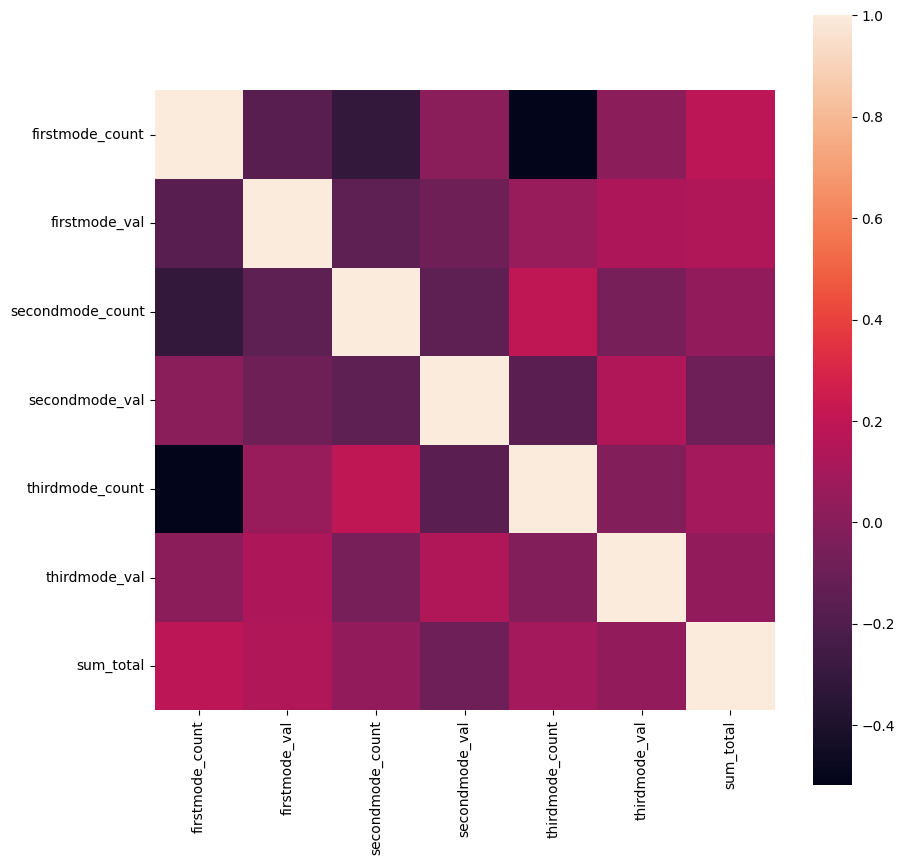

In [10]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cor, square=True)
plt.show()

In [11]:
scaler = StandardScaler()
X_std = scaler.fit_transform(features)

In [12]:
clt = AffinityPropagation(damping=0.5, max_iter=500, affinity="euclidean")

In [13]:
model = clt.fit(X_std)
n_clusters_ = len(model.cluster_centers_indices_)
print("Number of Clusters: ", n_clusters_)

Number of Clusters:  18


/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [14]:
clusters = pd.DataFrame(model.fit_predict(X_std))
features["Cluster"] = clusters

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [15]:
stations = df["station"]
stations = pd.concat((stations, features), axis=1)
stations = stations.rename({"station": "station", 0: "Cluster"}, axis=1)
sortstations = stations.sort_values(["station"])
sortstations["lon"] = ny_df_lons
sortstations["lat"] = ny_df_lats

In [16]:
colors = [
    "black",
    "blue",
    "white",
    "coral",
    "pink",
    "red",
    "magenta",
    "gray",
    "lime",
    "forestgreen",
    "green",
    "olive",
    "brown",
    "slategray",
    "darkorchid",
    "plum",
    "indigo",
    "purple",
    "yellow",
    "gold",
    "orange",
    "cyan",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortstations["color"] = sortstations["Cluster"].map(colordict)

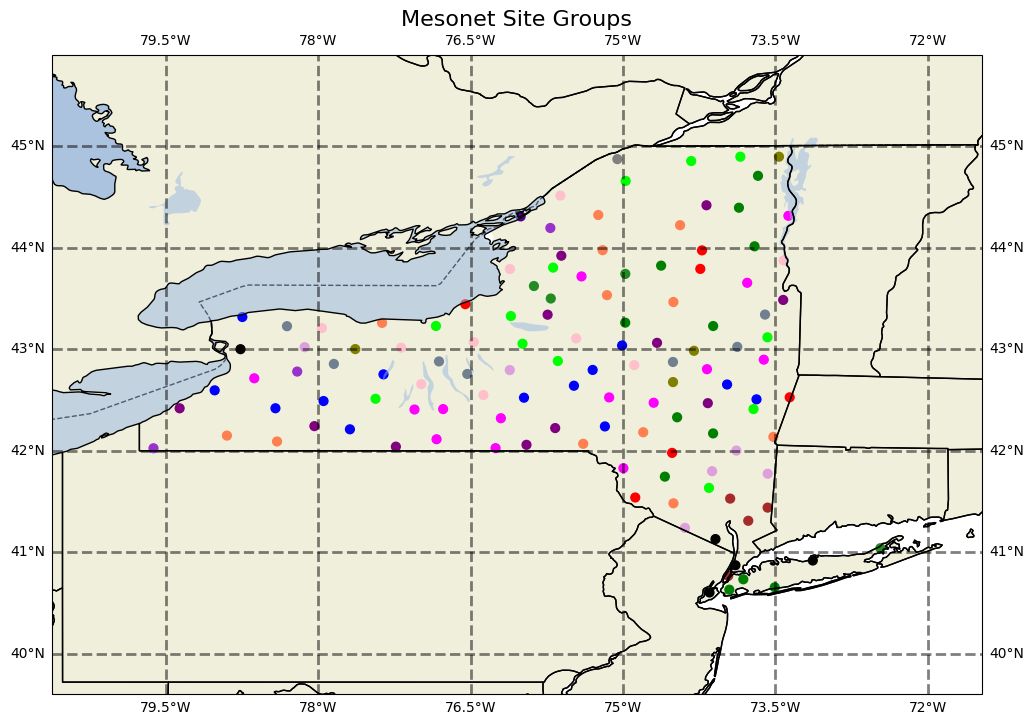

In [17]:
plurality_plot(sortstations)

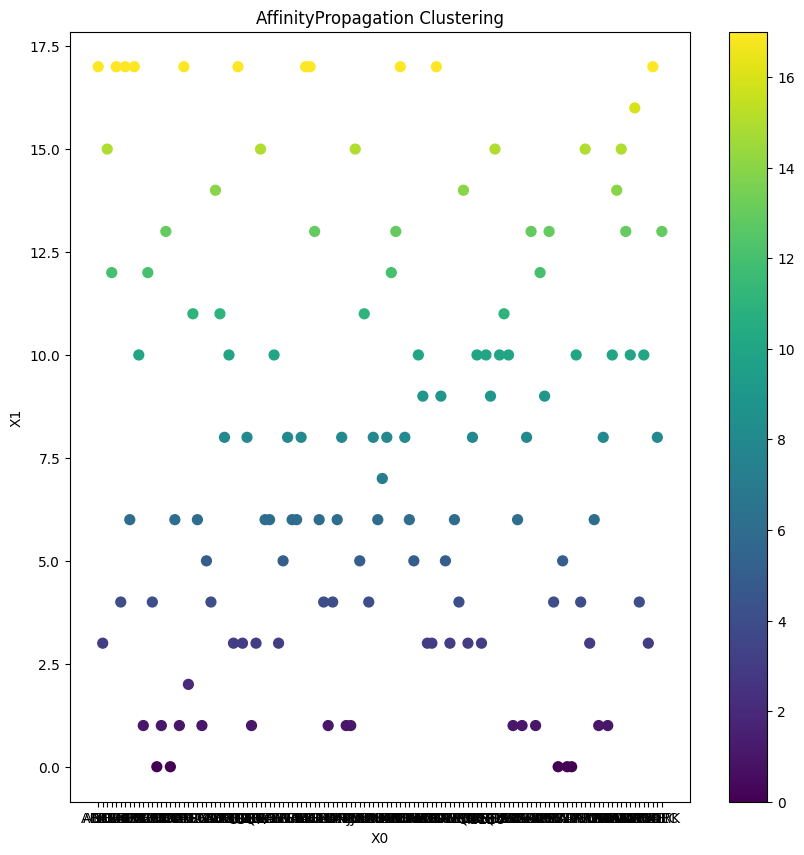

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(
    sortstations["station"], sortstations["Cluster"], c=sortstations["Cluster"], s=50
)
ax.set_title("AffinityPropagation Clustering")
ax.set_xlabel("X0")
ax.set_ylabel("X1")
plt.colorbar(scatter)
plt.show()

# let's cluster on elevation

In [19]:
elev_df = pd.read_csv("/home/aevans/landtype/elevation/data/NY/elev/ny30_df.csv")
elev_df.head()

,Unnamed: 0,station,elev,std,variance,skew,med_dist,lon,lat
0,0,ADDI,507.6140,78.927280,6227.304936,-0.137953,533.728027,-77.237259,42.040359
1,1,ANDE,518.2820,114.446243,13093.302806,0.554366,428.563965,-74.801392,42.182270
2,2,BATA,276.1200,81.741875,6679.365616,1.134595,325.239990,-78.135658,43.019939
3,3,BEAC,90.1598,77.445227,5995.644516,0.642901,43.319595,-73.945267,41.528751
4,4,BELD,470.3700,71.198890,5067.491291,-0.024945,520.739990,-75.668518,42.223221


In [20]:
# exclude the categorical columns
features_elev = elev_df.drop(["station", "Unnamed: 0", "lon", "lat"], axis=1)

In [21]:
cor_e = features_elev.corr()

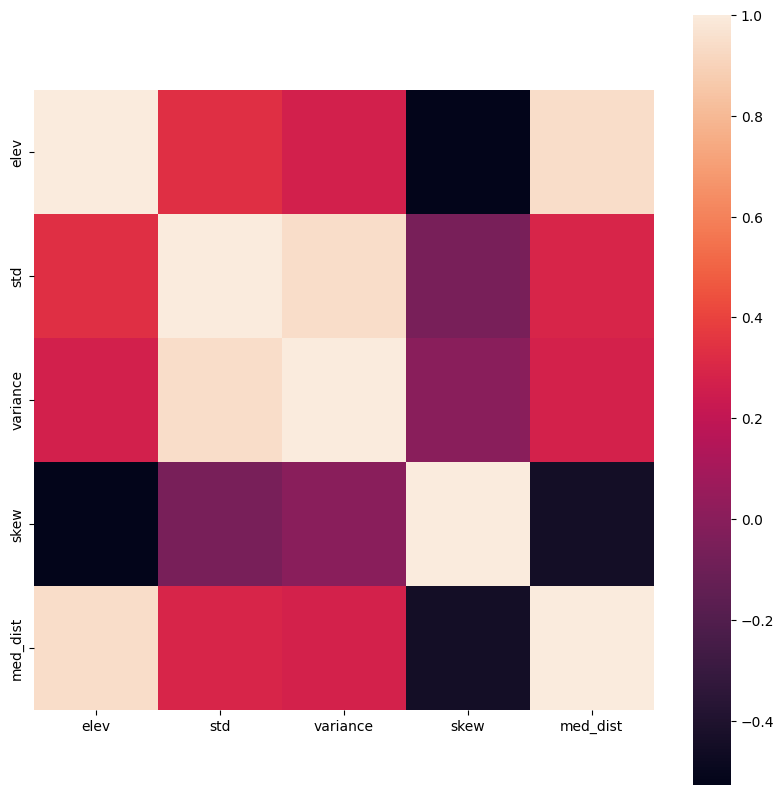

In [22]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cor_e, square=True)
plt.show()

In [23]:
scaler = StandardScaler()
X_std_e = scaler.fit_transform(features_elev)

In [24]:
clt_e = AffinityPropagation(damping=0.5, max_iter=500, affinity="euclidean")

In [25]:
model = clt_e.fit(X_std_e)
n_clusters_ = len(model.cluster_centers_indices_)
print("Number of Clusters: ", n_clusters_)

Number of Clusters:  13


/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [26]:
clusters_e = pd.DataFrame(model.fit_predict(X_std_e))
features_elev["Cluster"] = clusters_e

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [27]:
features_elev.head()

,elev,std,variance,skew,med_dist,Cluster
0,507.6140,78.927280,6227.304936,-0.137953,533.728027,10
1,518.2820,114.446243,13093.302806,0.554366,428.563965,12
2,276.1200,81.741875,6679.365616,1.134595,325.239990,11
3,90.1598,77.445227,5995.644516,0.642901,43.319595,5
4,470.3700,71.198890,5067.491291,-0.024945,520.739990,10


In [28]:
stations_elev = elev_df["station"]
stations_elev = pd.concat((stations_elev, features_elev), axis=1)
stations_elev = stations_elev.rename({"station": "station", 0: "Cluster"}, axis=1)
sortstations_e = stations_elev.sort_values(["station"])
sortstations_e["lon"] = ny_df_lons
sortstations_e["lat"] = ny_df_lats

In [29]:
colors = [
    "black",
    "blue",
    "white",
    "coral",
    "pink",
    "red",
    "magenta",
    "gray",
    "lime",
    "forestgreen",
    "green",
    "olive",
    "brown",
    "slategray",
    "darkorchid",
    "plum",
    "indigo",
    "purple",
    "yellow",
    "gold",
    "orange",
    "cyan",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortstations_e["color"] = sortstations_e["Cluster"].map(colordict)

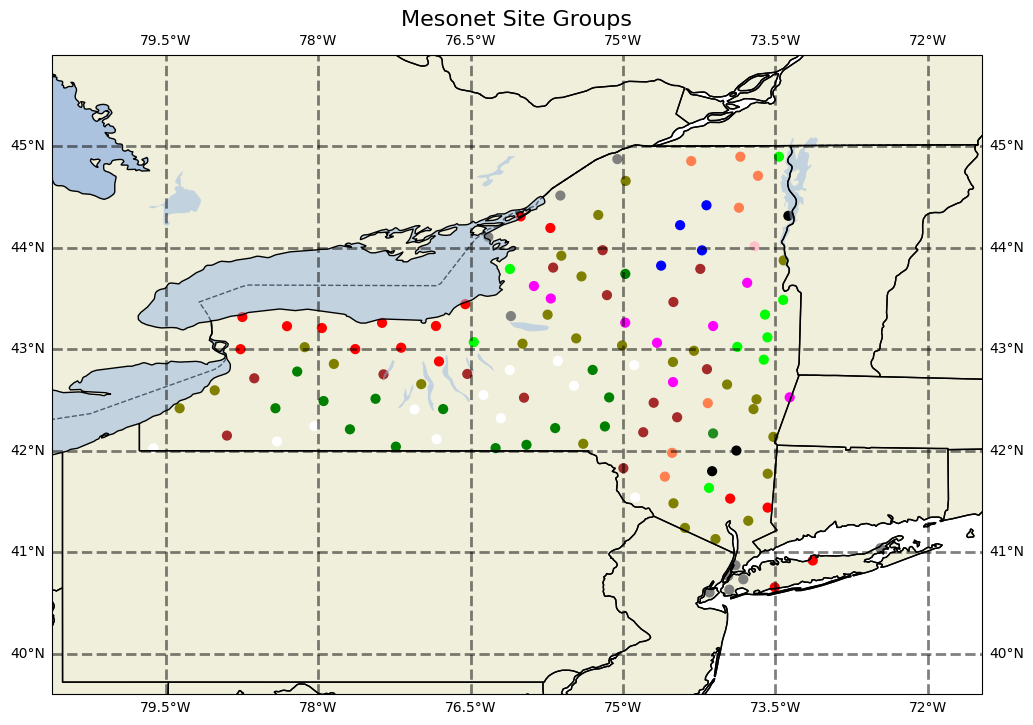

In [30]:
plurality_plot(sortstations_e)

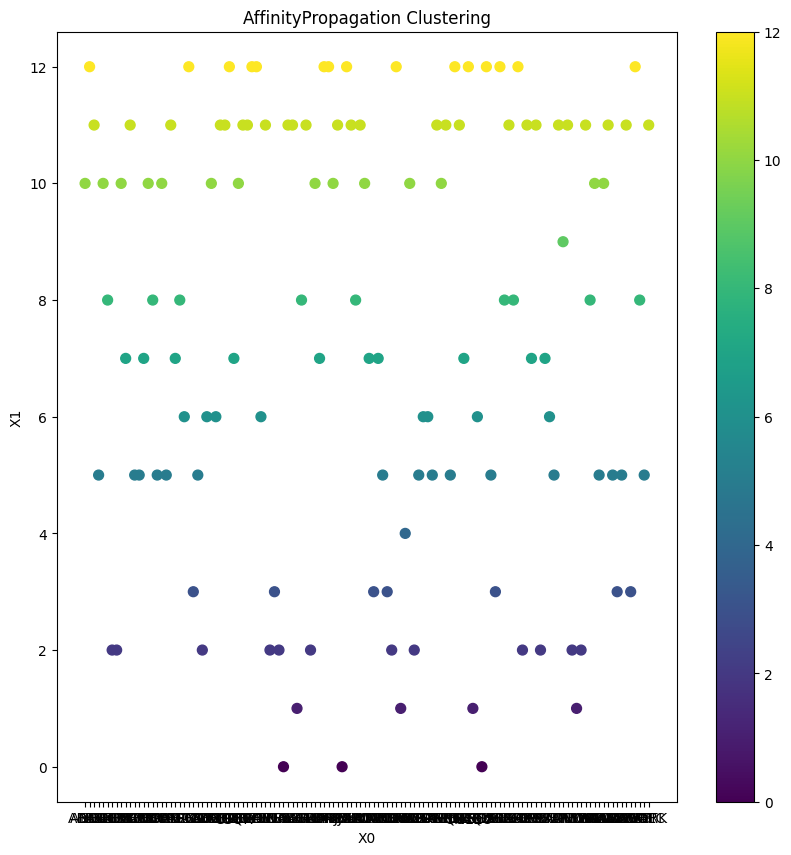

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(
    sortstations_e["station"],
    sortstations_e["Cluster"],
    c=sortstations_e["Cluster"],
    s=50,
)
ax.set_title("AffinityPropagation Clustering")
ax.set_xlabel("X0")
ax.set_ylabel("X1")
plt.colorbar(scatter)
plt.show()

# Let's Cluster on Slope

In [32]:
slope_df = pd.read_csv("/home/aevans/landtype/elevation/data/NY/elev/slope30_ny_df.csv")
slope_df.head()

,Unnamed: 0,Station,Mode,Count,Sum_total,Divide,Direction,Slope,color,lon,lat
0,0,ADDI,22,84.0,2736.0,3.070175,NE,LOW,aquamarine,-77.237259,42.040359
1,1,ANDE,28,225.0,2823.0,7.970244,NW,LOW,lightyellow,-74.801392,42.182270
2,2,BATA,23,23.0,2738.0,0.840029,E,LOW,lightskyblue,-78.135658,43.019939
3,3,BEAC,23,100.0,2785.0,3.590664,E,LOW,lightskyblue,-73.945267,41.528751
4,4,BELD,27,105.0,2831.0,3.708937,W,LOW,bisque,-75.668518,42.223221


In [33]:
# exclude the categorical columns
features_slope = slope_df.drop(
    ["Station", "Unnamed: 0", "Direction", "Slope", "color"], axis=1
)

In [34]:
cor_s = features_slope.corr()

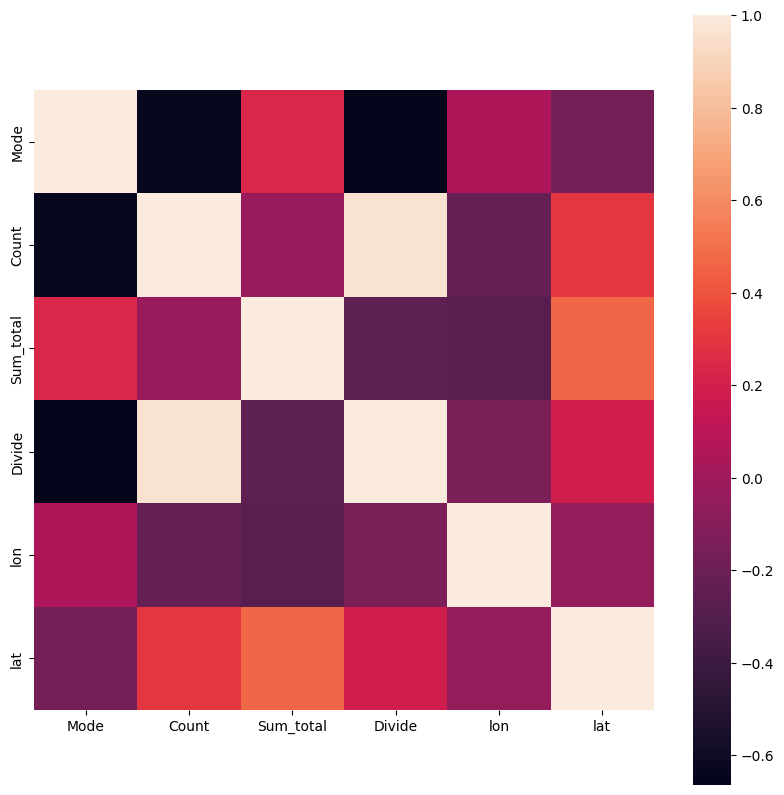

In [35]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cor_s, square=True)
plt.show()

In [36]:
scaler = StandardScaler()
X_std_s = scaler.fit_transform(features_slope)

In [37]:
clt_s = AffinityPropagation(damping=0.5, max_iter=500, affinity="euclidean")

In [38]:
model = clt_s.fit(X_std_s)
n_clusters_ = len(model.cluster_centers_indices_)
print("Number of Clusters: ", n_clusters_)

Number of Clusters:  13


/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [39]:
clusters_s = pd.DataFrame(model.fit_predict(X_std_s))
features_slope["Cluster"] = clusters_s

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [40]:
features_slope.head()

,Mode,Count,Sum_total,Divide,lon,lat,Cluster
0,22,84.0,2736.0,3.070175,-77.237259,42.040359,0
1,28,225.0,2823.0,7.970244,-74.801392,42.182270,7
2,23,23.0,2738.0,0.840029,-78.135658,43.019939,0
3,23,100.0,2785.0,3.590664,-73.945267,41.528751,10
4,27,105.0,2831.0,3.708937,-75.668518,42.223221,7


In [41]:
stations_slope = slope_df["Station"]
stations_slope = pd.concat((stations_slope, features_slope), axis=1)
stations_slope = stations_slope.rename({"Station": "station", 0: "Cluster"}, axis=1)
sortstations_s = stations_slope.sort_values(["station"])
sortstations_e["lon"] = ny_df_lons
sortstations_e["lat"] = ny_df_lats

In [42]:
sortstations_s.head()

,station,Mode,Count,Sum_total,Divide,lon,lat,Cluster
0,ADDI,22,84.0,2736.0,3.070175,-77.237259,42.040359,0
1,ANDE,28,225.0,2823.0,7.970244,-74.801392,42.182270,7
2,BATA,23,23.0,2738.0,0.840029,-78.135658,43.019939,0
3,BEAC,23,100.0,2785.0,3.590664,-73.945267,41.528751,10
4,BELD,27,105.0,2831.0,3.708937,-75.668518,42.223221,7


In [43]:
colors = [
    "black",
    "blue",
    "white",
    "coral",
    "pink",
    "red",
    "magenta",
    "gray",
    "lime",
    "forestgreen",
    "green",
    "olive",
    "brown",
    "slategray",
    "darkorchid",
    "plum",
    "indigo",
    "purple",
    "yellow",
    "gold",
    "orange",
    "cyan",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortstations_s["color"] = sortstations_s["Cluster"].map(colordict)

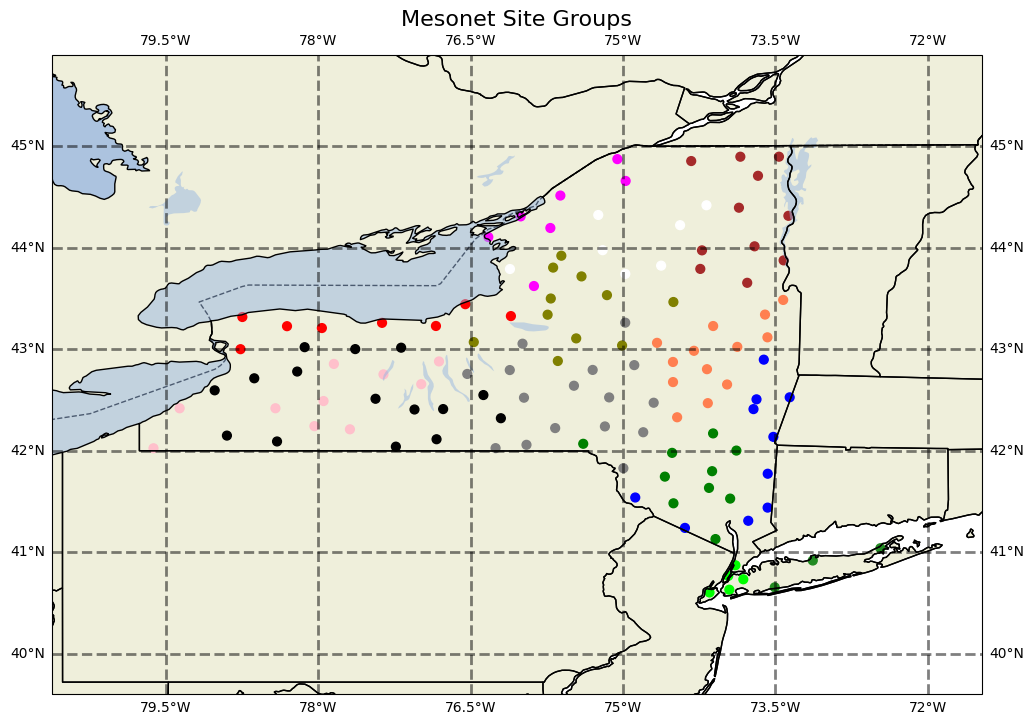

In [44]:
plurality_plot(sortstations_s)

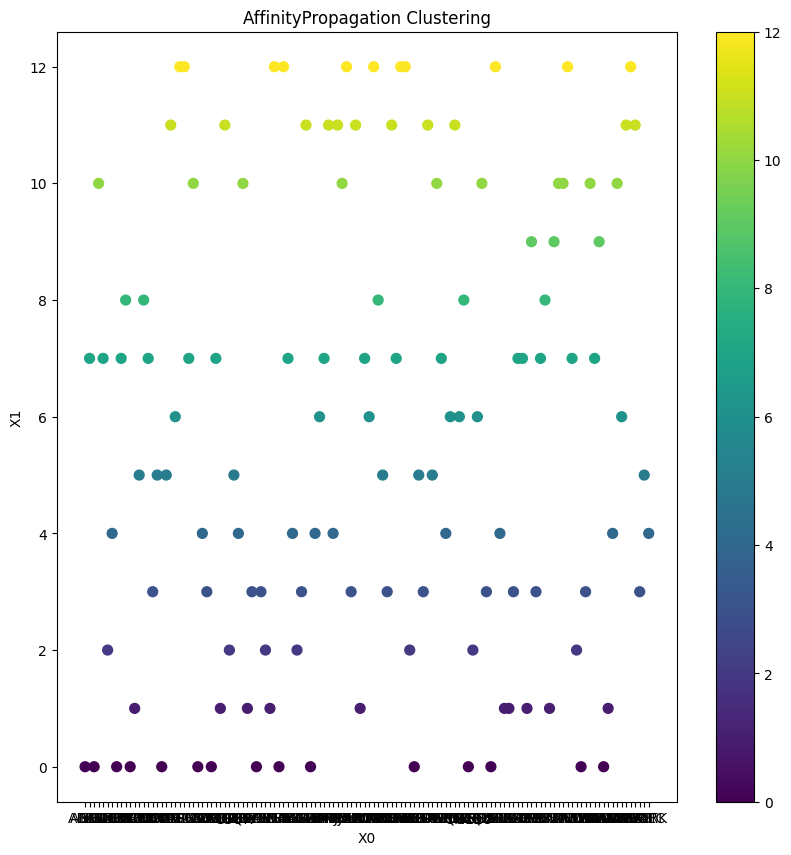

In [45]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(
    sortstations_s["station"],
    sortstations_s["Cluster"],
    c=sortstations_s["Cluster"],
    s=50,
)
ax.set_title("AffinityPropagation Clustering")
ax.set_xlabel("X0")
ax.set_ylabel("X1")
plt.colorbar(scatter)
plt.show()

# Let's try them all together

In [46]:
stations_ls = df["station"]

In [47]:
sortstations_s.head()

,station,Mode,Count,Sum_total,Divide,lon,lat,Cluster,color
0,ADDI,22,84.0,2736.0,3.070175,-77.237259,42.040359,0,black
1,ANDE,28,225.0,2823.0,7.970244,-74.801392,42.182270,7,gray
2,BATA,23,23.0,2738.0,0.840029,-78.135658,43.019939,0,black
3,BEAC,23,100.0,2785.0,3.590664,-73.945267,41.528751,10,green
4,BELD,27,105.0,2831.0,3.708937,-75.668518,42.223221,7,gray


In [48]:
daddy = pd.merge(sortstations, sortstations_e, on="station")
dad_df = pd.merge(daddy, sortstations_s, on="station")
dad_df = dad_df.drop(
    columns=[
        "station",
        "Cluster_x",
        "Cluster",
        "Cluster_y",
        "lon",
        "lat",
        "lon_x",
        "lat_x",
        "lon_y",
        "lat_y",
        "color",
        "color_x",
        "color_y",
        "sum_total",
        "Sum_total",
        "Divide",
        "Count",
    ]
)
dad_df

,firstmode_count,firstmode_val,secondmode_count,secondmode_val,thirdmode_count,thirdmode_val,elev,std,variance,skew,med_dist,Mode
0,102510.0,41,89978.0,43,89646.0,81,507.6140,78.927280,6227.304936,-0.137953,533.728027,22
1,231578.0,41,38639.0,43,38113.0,81,518.2820,114.446243,13093.302806,0.554366,428.563965,28
2,188167.0,82,43152.0,90,32775.0,81,276.1200,81.741875,6679.365616,1.134595,325.239990,23
3,149074.0,41,38782.0,21,37181.0,11,90.1598,77.445227,5995.644516,0.642901,43.319595,23
4,111398.0,43,99057.0,41,77808.0,81,470.3700,71.198890,5067.491291,-0.024945,520.739990,27
...,...,...,...,...,...,...,...,...,...,...,...,...
121,135606.0,41,120244.0,42,52521.0,43,614.5990,202.243862,40888.106084,0.829412,732.197998,23
122,180873.0,41,60672.0,42,58405.0,90,442.9660,110.331076,12168.634202,0.331919,443.932007,24
123,107507.0,41,84855.0,42,64891.0,81,36.5638,131.505260,17287.501027,0.896057,-115.872398,23
124,110212.0,41,87370.0,82,38749.0,90,121.2190,30.201774,911.824410,-0.081195,120.438004,19


In [49]:
cor_d = dad_df.corr()

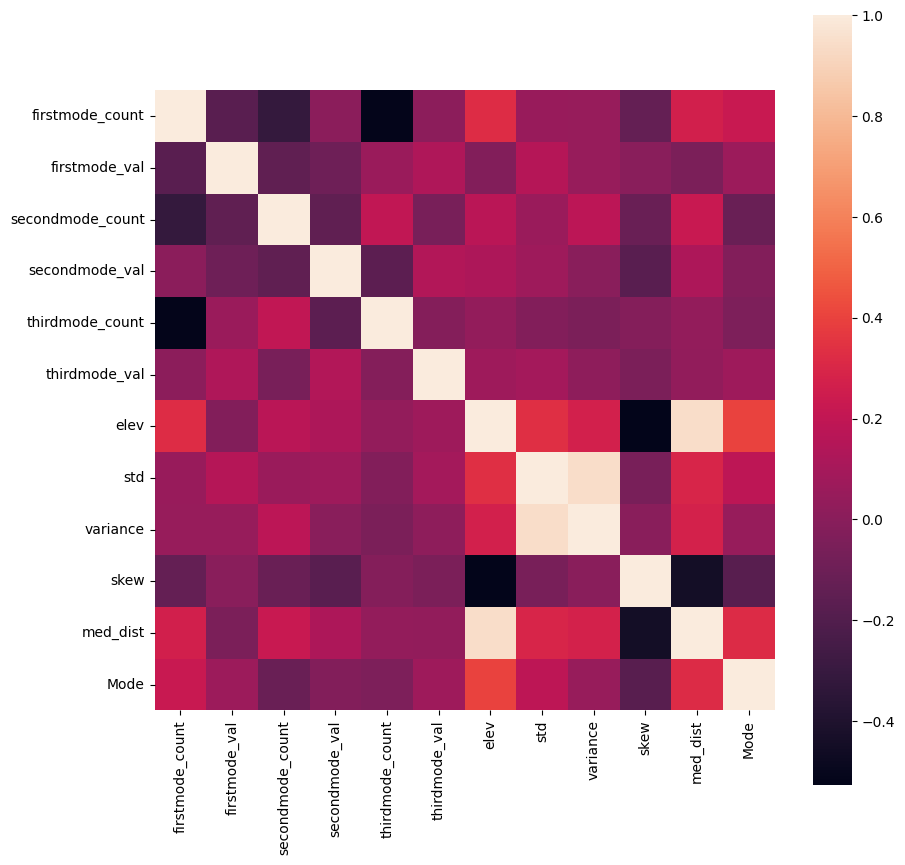

In [50]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cor_d, square=True)
plt.show()

In [51]:
scaler = StandardScaler()
X_std_d = scaler.fit_transform(dad_df)

In [52]:
model = clt.fit(X_std_d)
n_clusters_ = len(model.cluster_centers_indices_)
print("Number of Clusters: ", n_clusters_)

Number of Clusters:  17


/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [53]:
clusters_d = pd.DataFrame(model.fit_predict(X_std_d))
dad_df["Cluster"] = clusters_d

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [54]:
stations_d = df["station"]
stations_d = pd.concat((stations_d, dad_df), axis=1)
stations_d = stations_d.rename({"station": "station", 0: "Cluster"}, axis=1)
sortstations_d = stations_d.sort_values(["station"])
sortstations_d["lon"] = ny_df_lons
sortstations_d["lat"] = ny_df_lats

In [55]:
sortstations_d.head()

,station,firstmode_count,firstmode_val,secondmode_count,secondmode_val,thirdmode_count,thirdmode_val,elev,std,variance,skew,med_dist,Mode,Cluster,lon,lat
0,ADDI,102510.0,41,89978.0,43,89646.0,81,507.6140,78.927280,6227.304936,-0.137953,533.728027,22,0,-77.237259,42.040359
1,ANDE,231578.0,41,38639.0,43,38113.0,81,518.2820,114.446243,13093.302806,0.554366,428.563965,28,5,-74.801392,42.182270
2,BATA,188167.0,82,43152.0,90,32775.0,81,276.1200,81.741875,6679.365616,1.134595,325.239990,23,10,-78.135658,43.019939
3,BEAC,149074.0,41,38782.0,21,37181.0,11,90.1598,77.445227,5995.644516,0.642901,43.319595,23,14,-73.945267,41.528751
4,BELD,111398.0,43,99057.0,41,77808.0,81,470.3700,71.198890,5067.491291,-0.024945,520.739990,27,0,-75.668518,42.223221


In [56]:
colors = [
    "black",
    "blue",
    "white",
    "coral",
    "pink",
    "red",
    "magenta",
    "gray",
    "lime",
    "forestgreen",
    "green",
    "olive",
    "brown",
    "slategray",
    "darkorchid",
    "plum",
    "indigo",
    "purple",
    "yellow",
    "gold",
    "orange",
    "cyan",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortstations_d["color"] = sortstations_d["Cluster"].map(colordict)

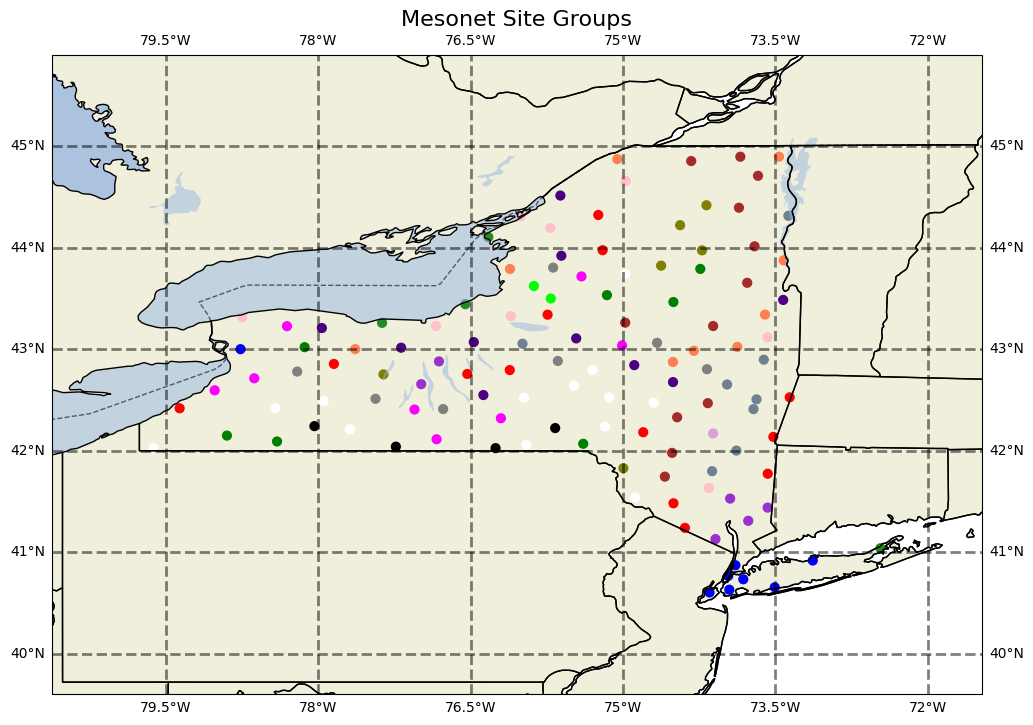

In [57]:
plurality_plot(sortstations_d)

In [58]:
for i in np.arange(0, 17):
    slopes_cat = sortstations_d.loc[sortstations_d["Cluster"] == i]
    slopes_cat = pd.merge(slopes_cat, daddy, on="station")
    slopes_cat.to_csv(f"/home/aevans/landtype/data/clean_cats/ny/aff/df_{i}.csv")

In [59]:
dirs = sorted(os.listdir("/home/aevans/landtype/data/clean_cats/ny/aff/"))

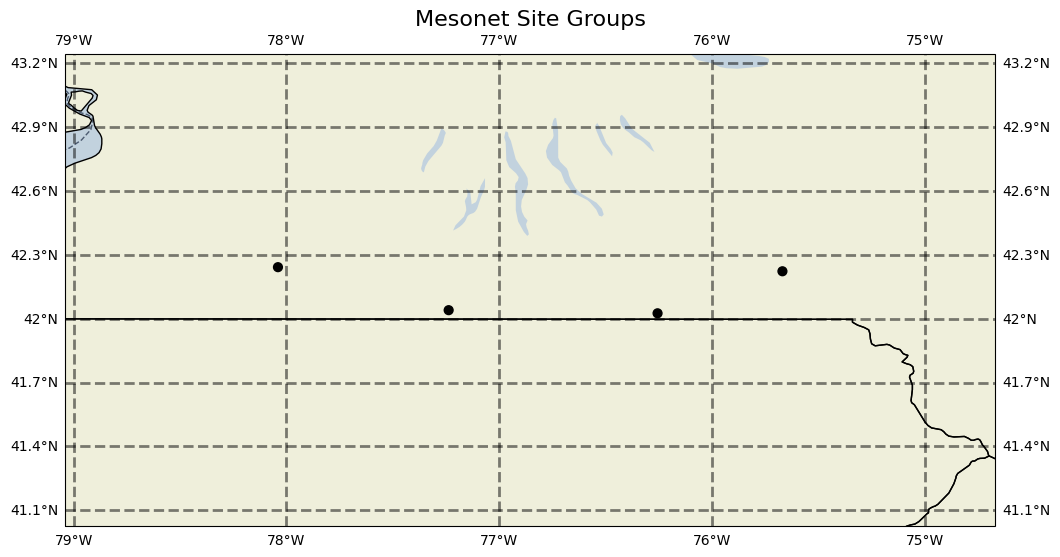

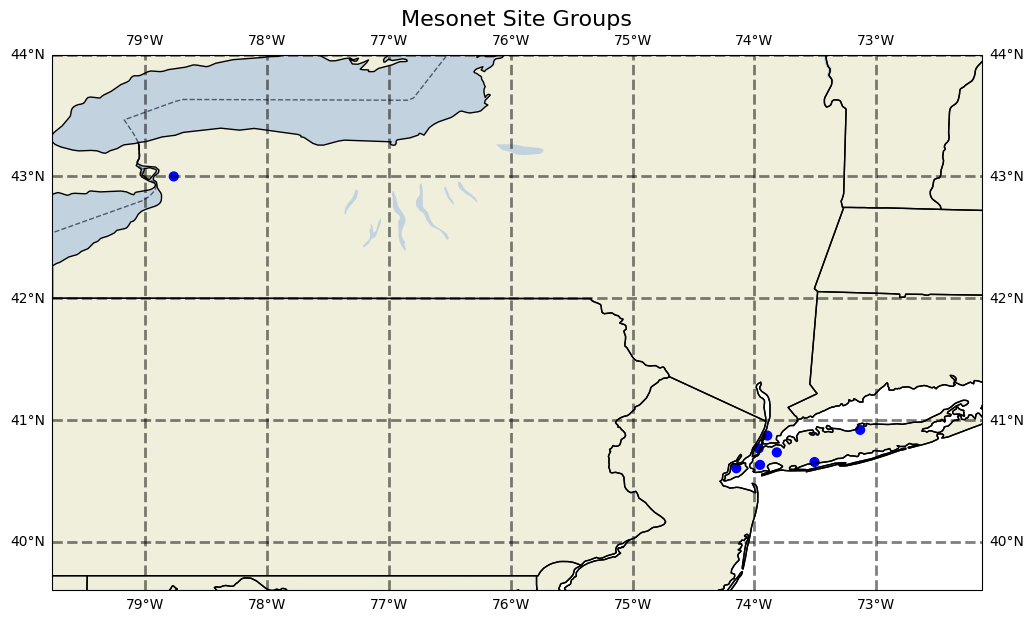

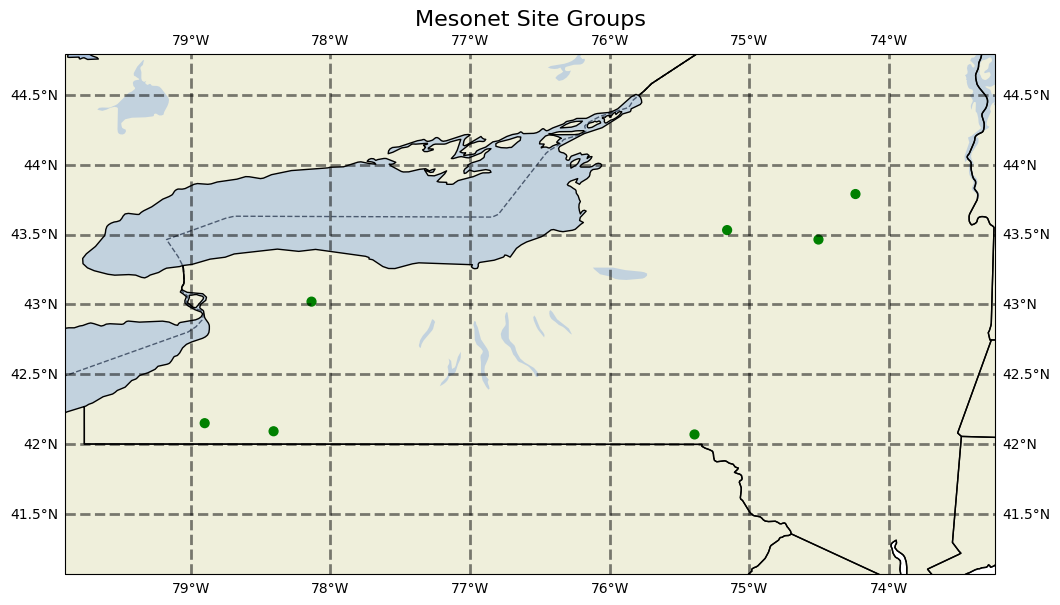

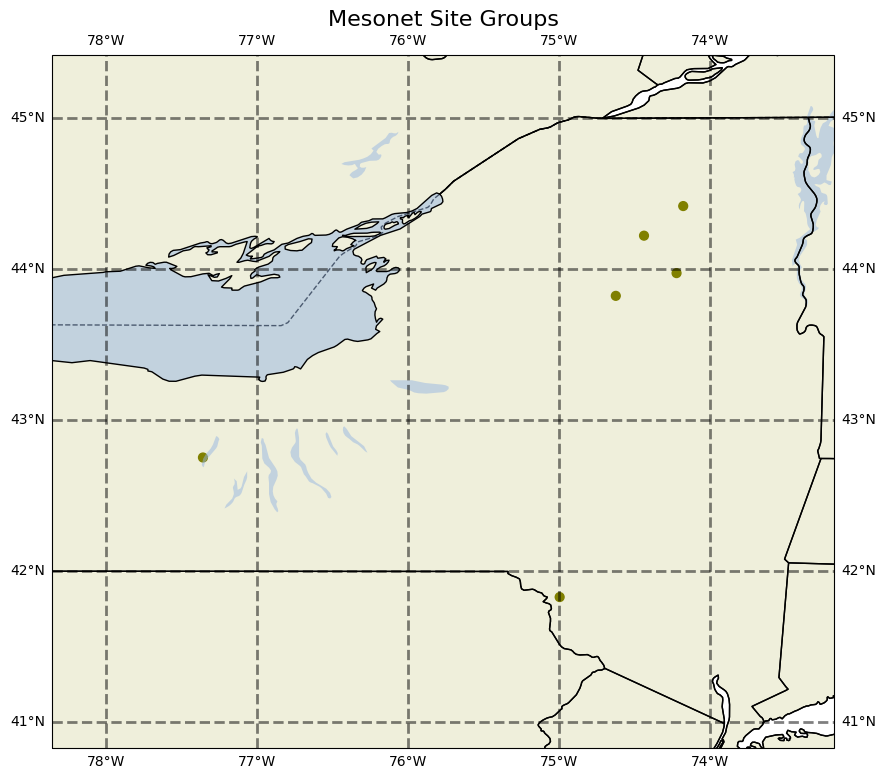

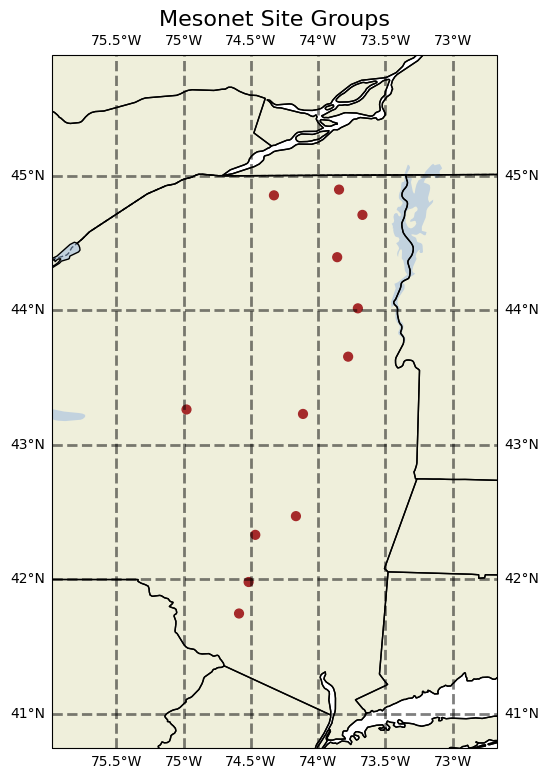

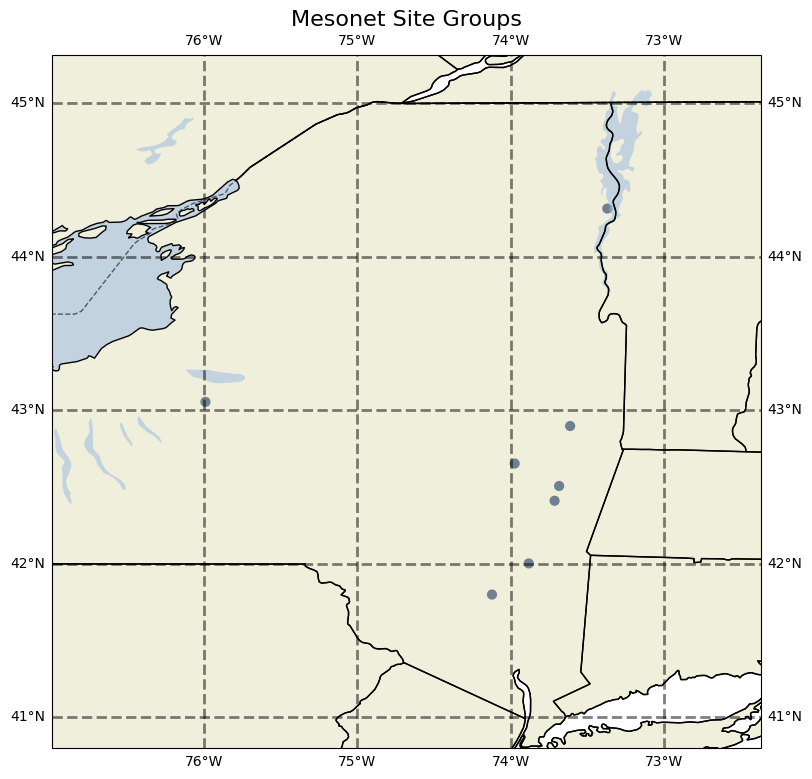

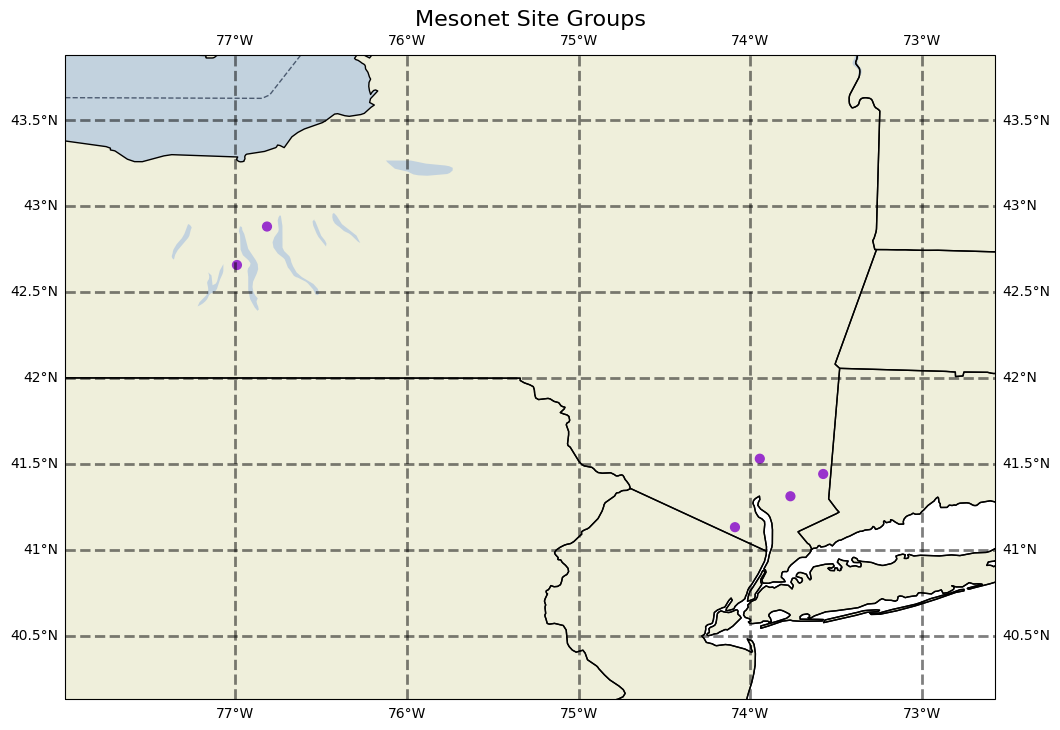

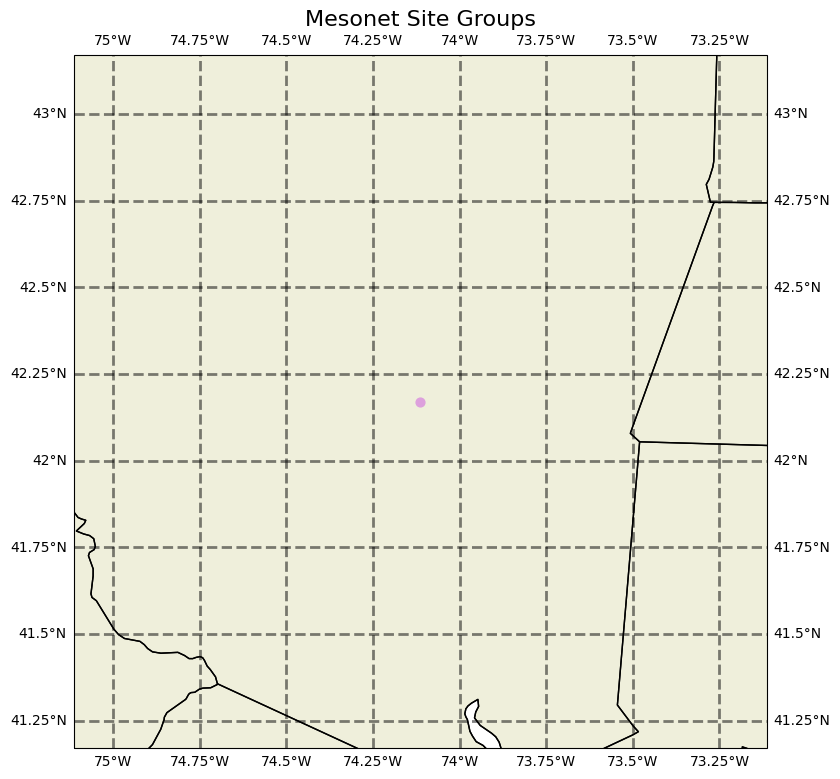

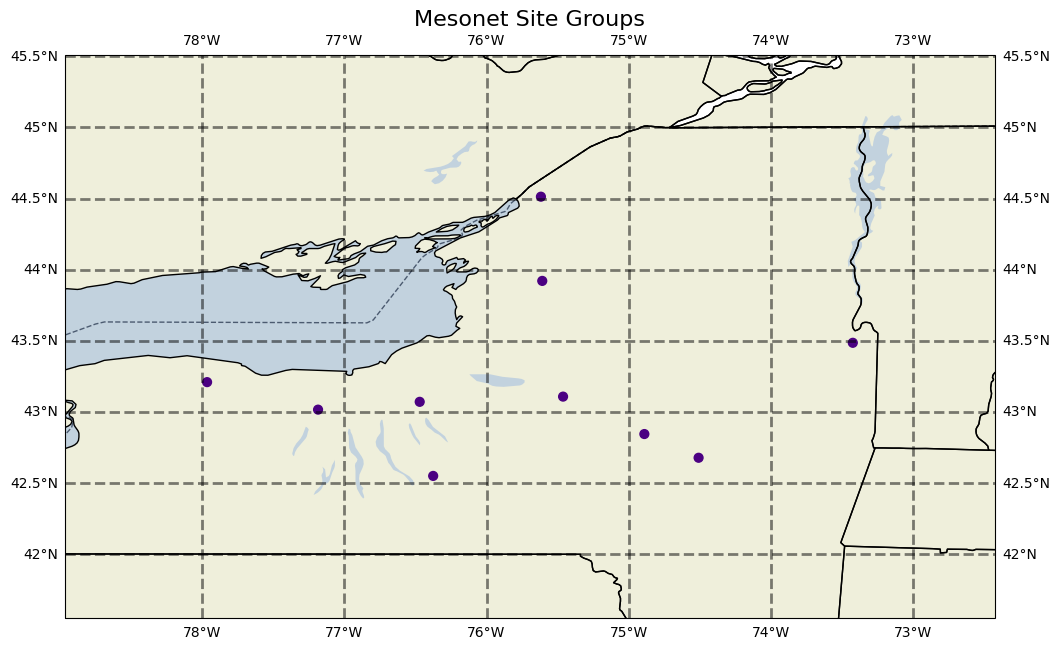

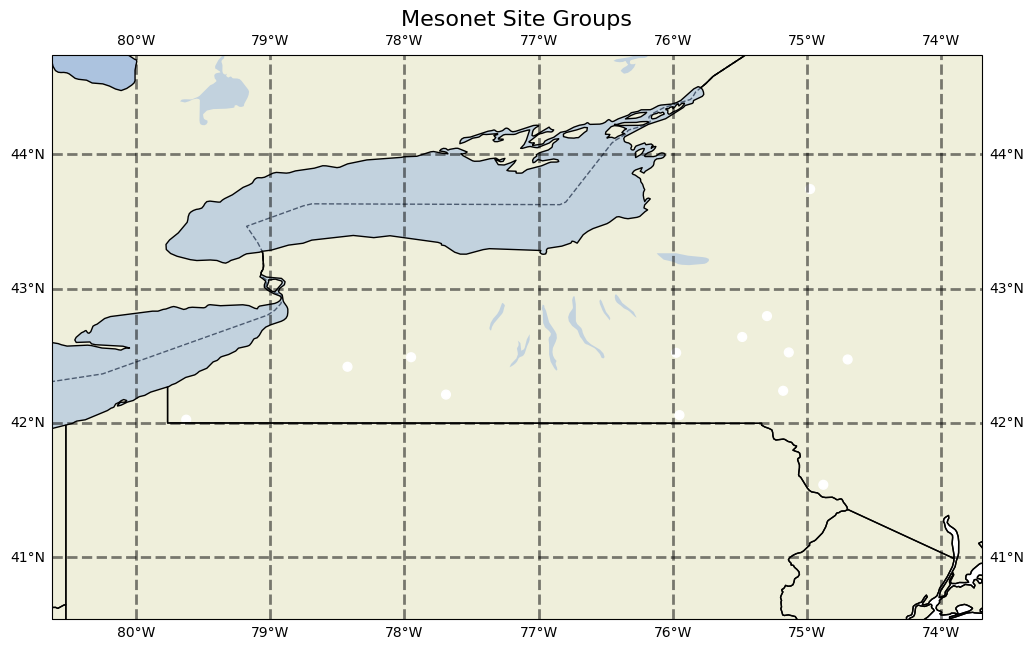

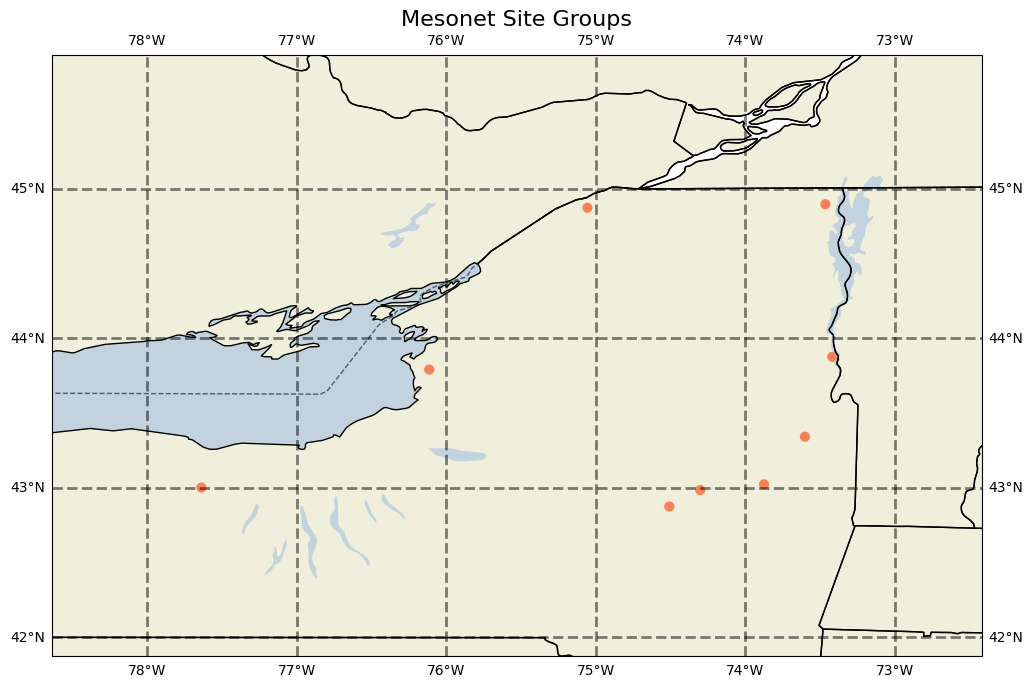

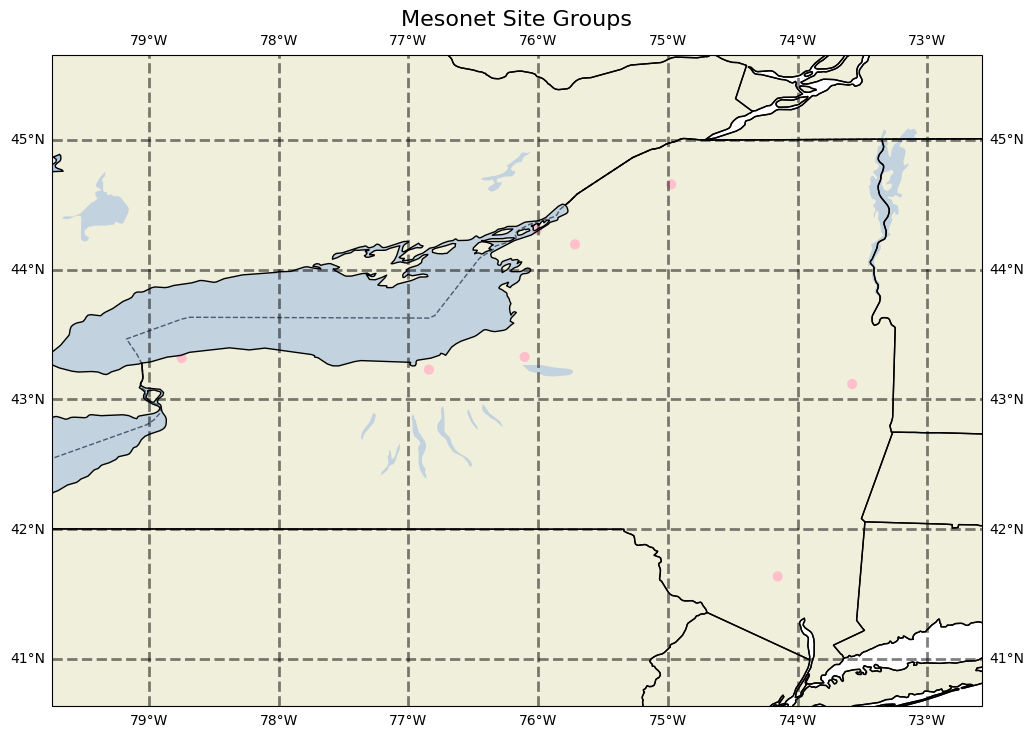

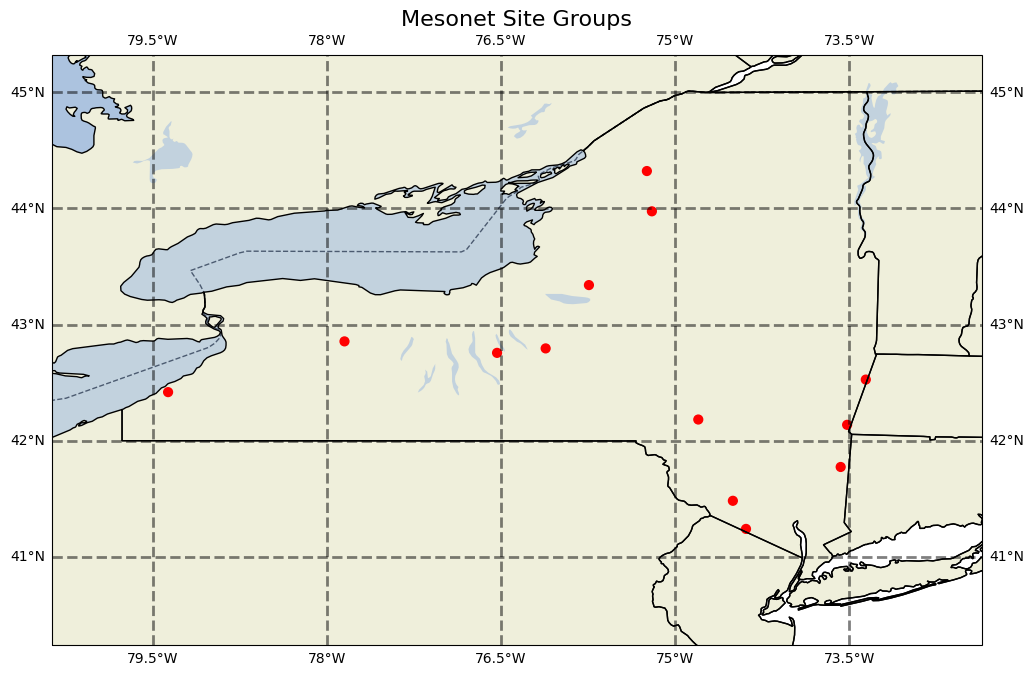

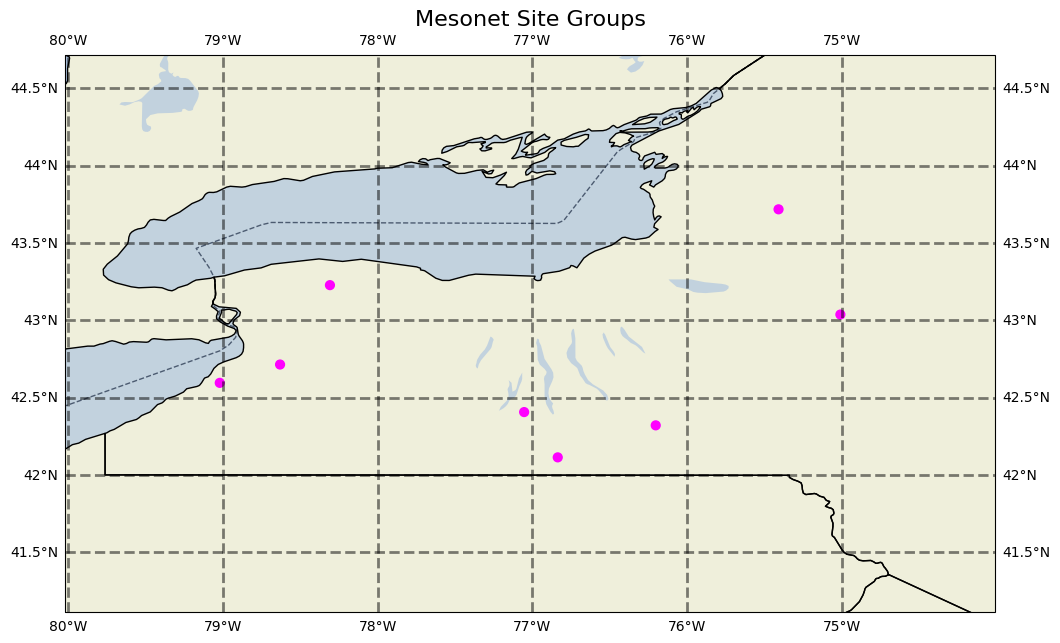

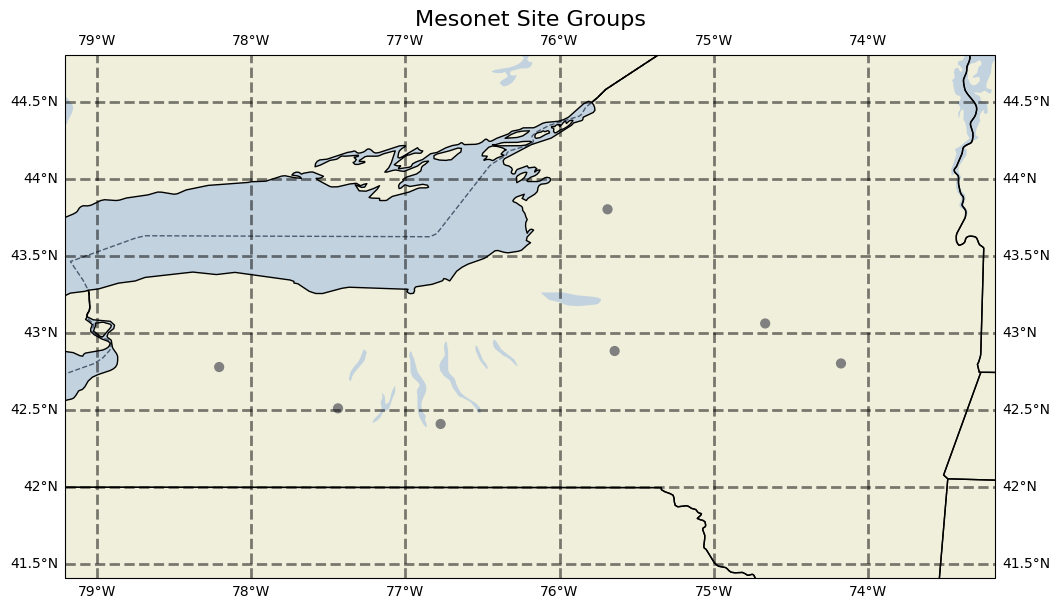

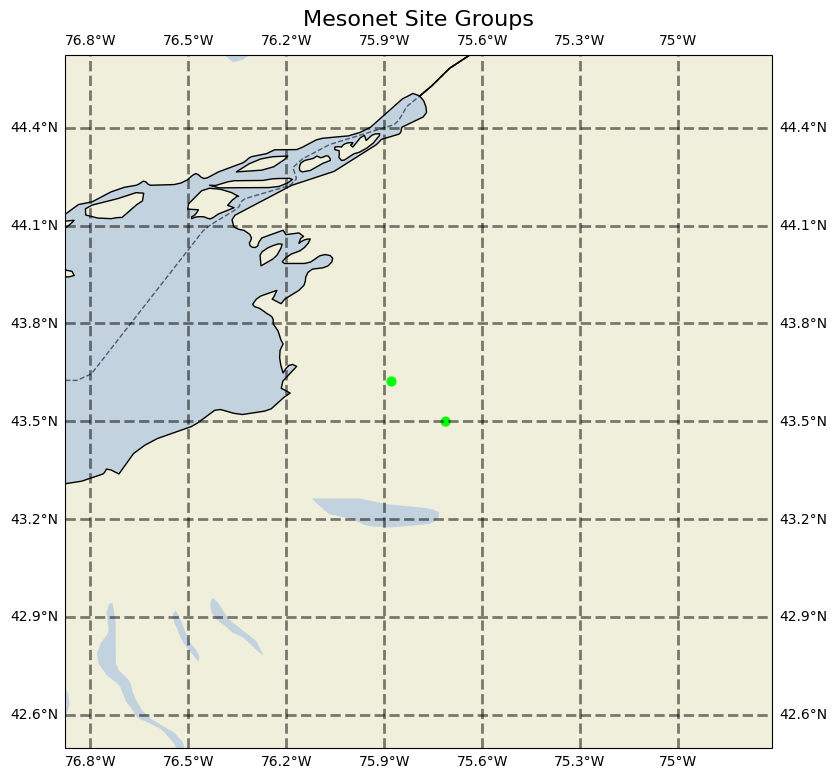

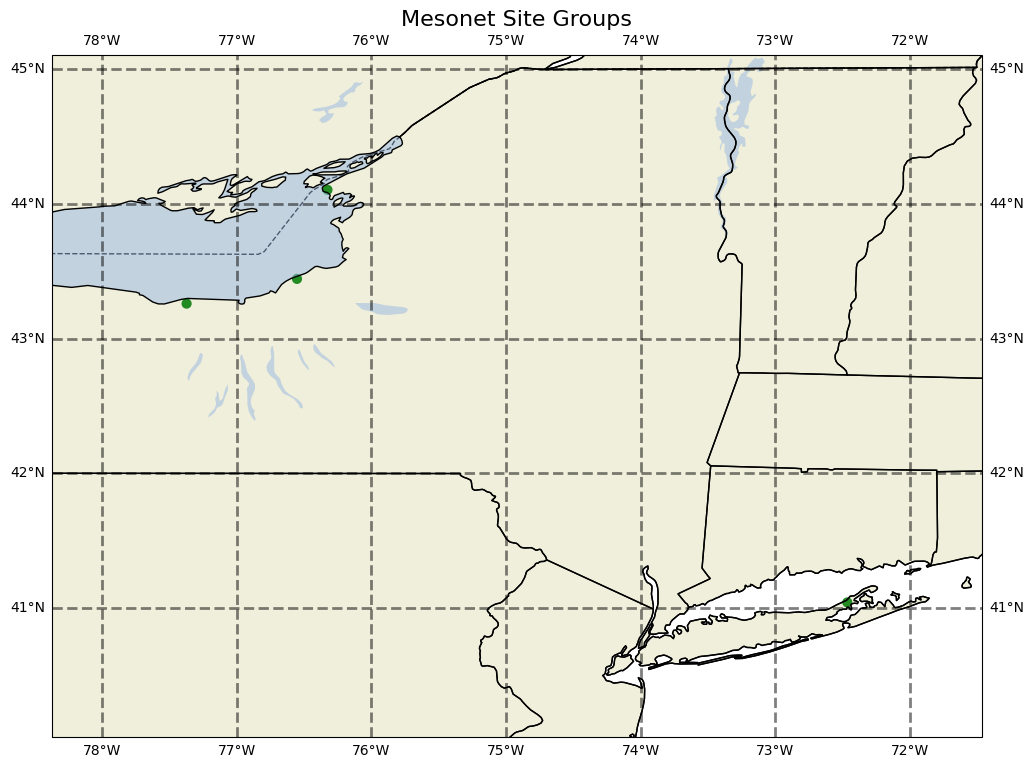

In [60]:
for n, _ in enumerate(dirs):
    df = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/aff/{dirs[n]}")
    plurality_plot(df)